###House Price Analysis and Prediction Project

#####Creating a Spark session for house price analysis and prediction

In [0]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("House Price Analysis and Prediction").getOrCreate()

#####Importing necessary libraries and modules for data processing, feature engineering, and machine learning

In [0]:
from pyspark.sql.functions import col, sum, year, month, dayofweek, quarter, when, concat, lit, current_date, avg, expr
from pyspark.sql.types import DoubleType, IntegerType, StringType
from pyspark.sql import Window
from pyspark.ml.feature import StringIndexer, OneHotEncoder,StandardScaler, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import seaborn as sns   
import matplotlib.pyplot as plt

#####Reading/Loading CSV file into a DataFrame with headers and automatic type inference

In [0]:
Zameen_Data_df = spark.read.csv("/FileStore/tables/zameen_updated-1.csv" , header= True, inferSchema=True)

#####Displaying the first 2 rows of the DataFrame

In [0]:
Zameen_Data_df.show(2)

+-----------+-----------+--------------------+-------------+--------+--------+---------+-----------------+---------+---------+-----+---------+--------+--------+----------+------+-----+---------+---------+-------------+
|property_id|location_id|            page_url|property_type|   price|location|     city|    province_name| latitude|longitude|baths|     area| purpose|bedrooms|date_added|agency|agent|Area Type|Area Size|Area Category|
+-----------+-----------+--------------------+-------------+--------+--------+---------+-----------------+---------+---------+-----+---------+--------+--------+----------+------+-----+---------+---------+-------------+
|     237062|       3325|https://www.zamee...|         Flat|10000000|    G-10|Islamabad|Islamabad Capital| 33.67989| 73.01264|    2|  4 Marla|For Sale|       2|2019-02-04|  null| null|    Marla|      4.0|    0-5 Marla|
|     346905|       3236|https://www.zamee...|         Flat| 6900000|    E-11|Islamabad|Islamabad Capital|33.700993|72.97149

#####Printing the schema (column names and types) of the DataFrame

In [0]:
Zameen_Data_df.printSchema()


root
 |-- property_id: integer (nullable = true)
 |-- location_id: integer (nullable = true)
 |-- page_url: string (nullable = true)
 |-- property_type: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- location: string (nullable = true)
 |-- city: string (nullable = true)
 |-- province_name: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- baths: integer (nullable = true)
 |-- area: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- date_added: date (nullable = true)
 |-- agency: string (nullable = true)
 |-- agent: string (nullable = true)
 |-- Area Type: string (nullable = true)
 |-- Area Size: double (nullable = true)
 |-- Area Category: string (nullable = true)



###Data Cleaning and Exploration

#####Calculating the number of missing values for each column in the DataFrame

In [0]:
missing_val_df = Zameen_Data_df.select( [sum(col(c).isNull().cast("int")).alias(c) for c in Zameen_Data_df.columns])

#####Displaying the DataFrame with the count of missing values for each column

In [0]:
missing_val_df.show()

+-----------+-----------+--------+-------------+-----+--------+----+-------------+--------+---------+-----+----+-------+--------+----------+------+-----+---------+---------+-------------+
|property_id|location_id|page_url|property_type|price|location|city|province_name|latitude|longitude|baths|area|purpose|bedrooms|date_added|agency|agent|Area Type|Area Size|Area Category|
+-----------+-----------+--------+-------------+-----+--------+----+-------------+--------+---------+-----+----+-------+--------+----------+------+-----+---------+---------+-------------+
|          0|          0|       0|            0|    0|       0|   0|            0|       0|        0|    0|   0|      0|       0|         0| 42941|42942|        0|        0|            0|
+-----------+-----------+--------+-------------+-----+--------+----+-------------+--------+---------+-----+----+-------+--------+----------+------+-----+---------+---------+-------------+



#####Filling the missing values in 'agency' and 'agent' columns with 'unknown' and display the first 5 rows

In [0]:
Zameen_Data_df = Zameen_Data_df.fillna(
    {
        "agency": "unknown", "agent": "unknown"
    }
)

Zameen_Data_df.show(5)

+-----------+-----------+--------------------+-------------+--------+-----------+---------+-----------------+-----------+-----------+-----+---------+--------+--------+----------+-------------+--------------------+---------+---------+-------------+
|property_id|location_id|            page_url|property_type|   price|   location|     city|    province_name|   latitude|  longitude|baths|     area| purpose|bedrooms|date_added|       agency|               agent|Area Type|Area Size|Area Category|
+-----------+-----------+--------------------+-------------+--------+-----------+---------+-----------------+-----------+-----------+-----+---------+--------+--------+----------+-------------+--------------------+---------+---------+-------------+
|     237062|       3325|https://www.zamee...|         Flat|10000000|       G-10|Islamabad|Islamabad Capital|   33.67989|   73.01264|    2|  4 Marla|For Sale|       2|2019-02-04|      unknown|             unknown|    Marla|      4.0|    0-5 Marla|
|     34

#####Showing summary statistics (count, mean, stddev, min, max) for selected columns

In [0]:
Zameen_Data_df.select("property_id", "location_id" ,"price", "latitude", "longitude", "baths", "bedrooms", "Area Size").describe().show()

+-------+--------------------+-----------------+-------------------+------------------+-----------------+------------------+------------------+-----------------+
|summary|         property_id|      location_id|              price|          latitude|        longitude|             baths|          bedrooms|        Area Size|
+-------+--------------------+-----------------+-------------------+------------------+-----------------+------------------+------------------+-----------------+
|  count|              166946|           166946|             166946|            166946|           166946|            166946|            166946|           166946|
|   mean|1.5663765459316187E7|4376.241976447474|1.775734001232734E7| 29.85700916405727| 71.2370788387739|2.8701616091430764|3.1773687300085056|5.889773339882391|
| stddev|  2144986.8899090155| 3777.69673431494|3.531626929191833E7|3.8089981392430357|3.133418429837562| 2.464426740976242|1.9716261815690541|5.793006733297405|
|    min|               8657

#####Group by each specified column and count the number of occurrences

In [0]:
for column in ["property_type", "location", "city", "province_name", "purpose", "Area Type", "Area Category"]:
    Zameen_Data_df.groupBy(column).count().show()

+-------------+------+
|property_type| count|
+-------------+------+
|   Farm House|   651|
|         Flat| 37876|
|    Penthouse|   385|
|         Room|   677|
|        House|104501|
|Upper Portion| 13697|
|Lower Portion|  9159|
+-------------+------+

+--------------------+-----+
|            location|count|
+--------------------+-----+
|      Cavalry Ground|  146|
|Marghzar Officers...|  172|
|      Nishtar Colony|  154|
|          Nawab Town|   57|
|           Jora Pull|    9|
| Hawks Bay Scheme 42|    4|
|          Rawal Town|   15|
|Rehman City - Pha...|    8|
|          Kamal Abad|    1|
|    Lyari Expressway|   17|
|        Labor Colony|   92|
|Punjab Small Indu...|   50|
|            Township|  381|
|   Dhok Sayedan Road|   89|
|          Gawalmandi|    3|
|        Mustafa Abad|    3|
|   Chak 279/RB Kalan|    2|
|         Liaquatabad|  457|
|Multi Residencia ...|    9|
|         Sarwar Road|    3|
+--------------------+-----+
only showing top 20 rows

+----------+-----+
|    

#####Ploting histograms for each numeric feature in the DataFrame

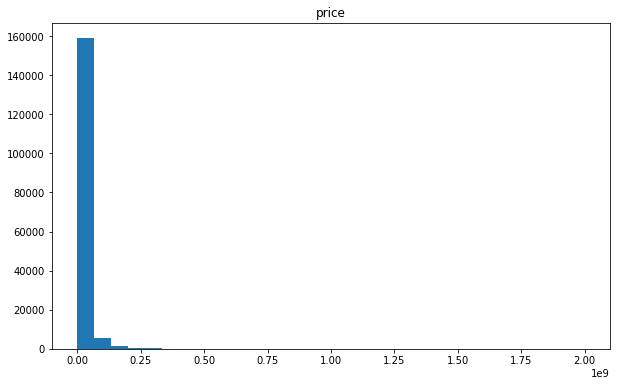

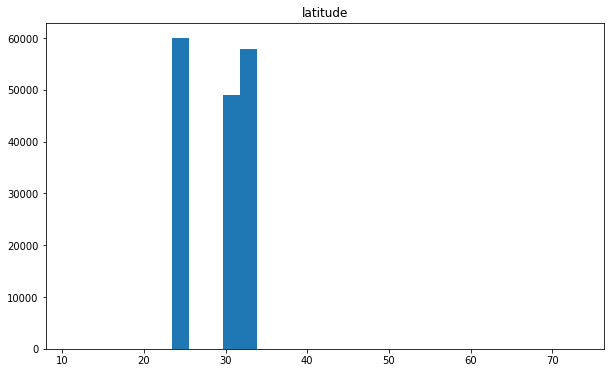

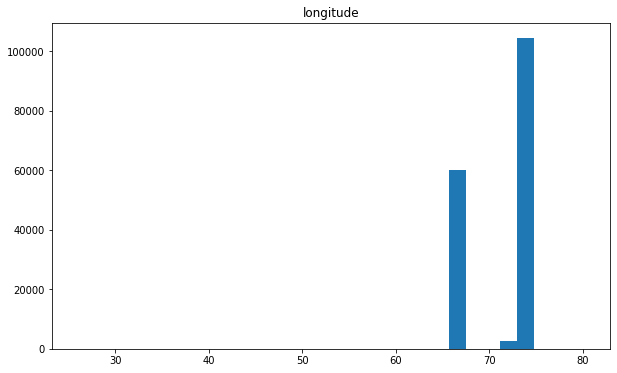

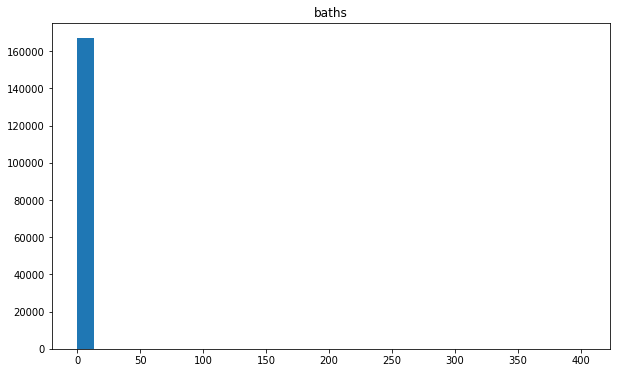

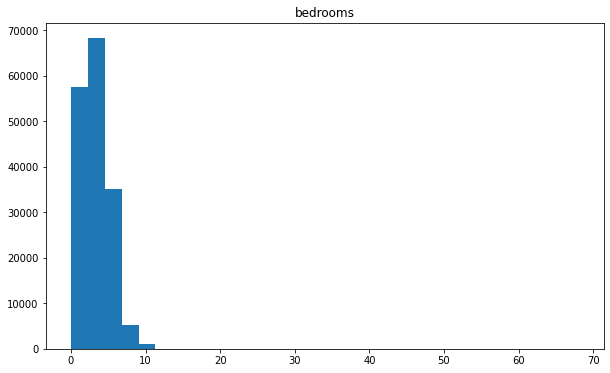

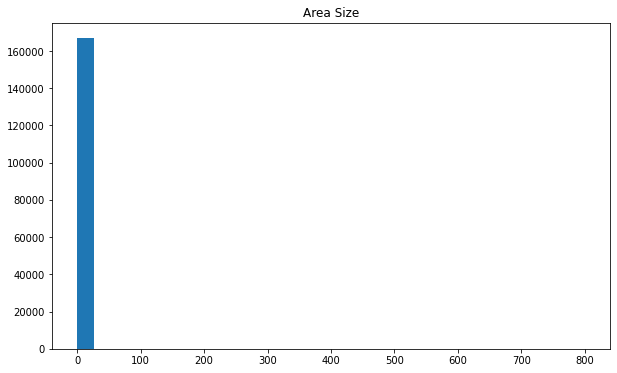

In [0]:
numeric_features = ["price", "latitude", "longitude", "baths", "bedrooms", "Area Size"]
for feature in numeric_features:
    Zameen_Data_df.select(feature).toPandas().hist(column=feature, bins=30, grid=False, figsize=(10, 6))

#####Calculating and ploting the correlation matrix for numeric features

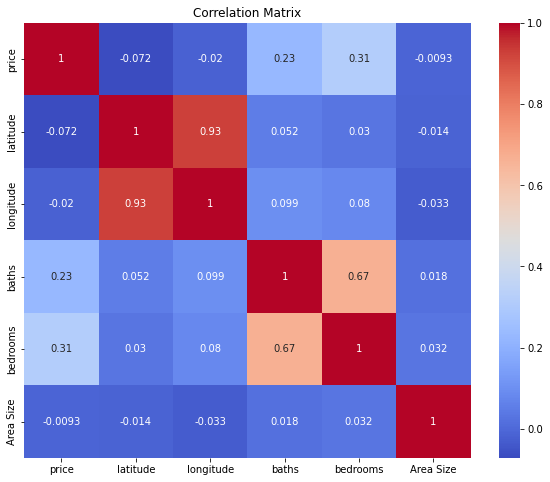

In [0]:
correlations = Zameen_Data_df.select(numeric_features).toPandas().corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


#####Ploting bar charts showing the distribution of each categorical feature

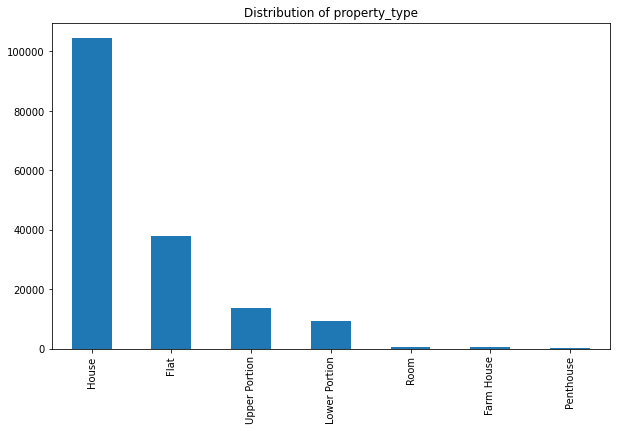

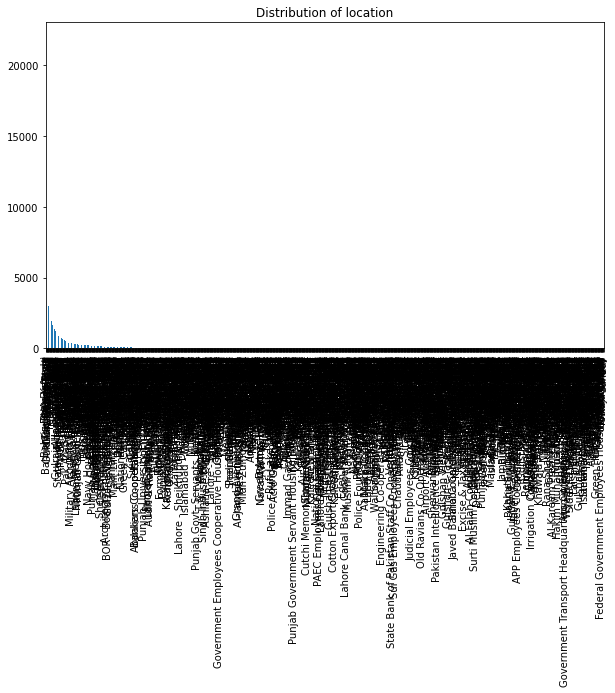

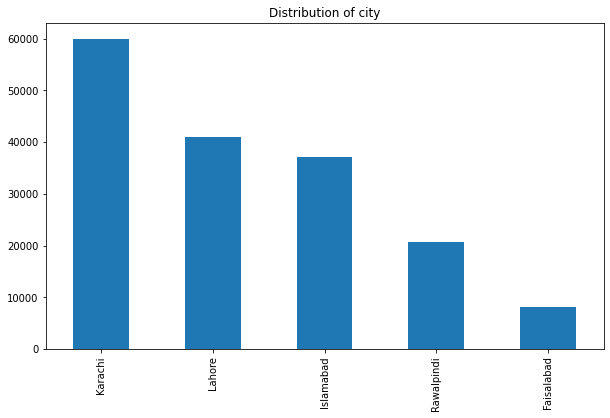

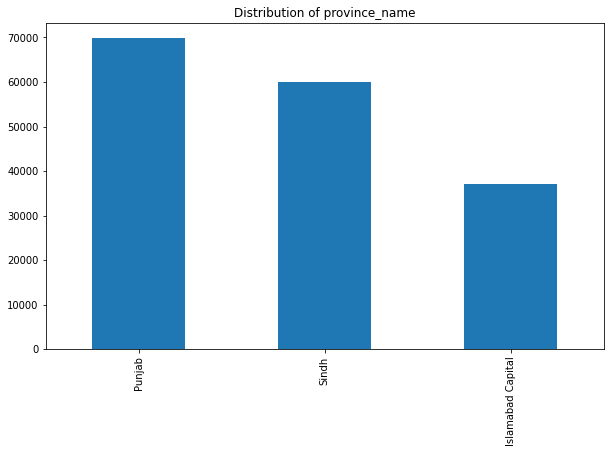

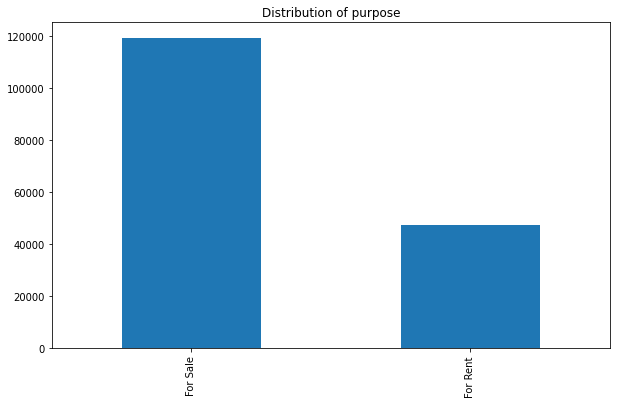

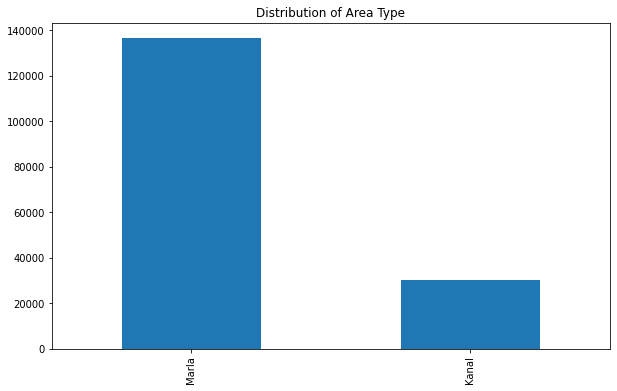

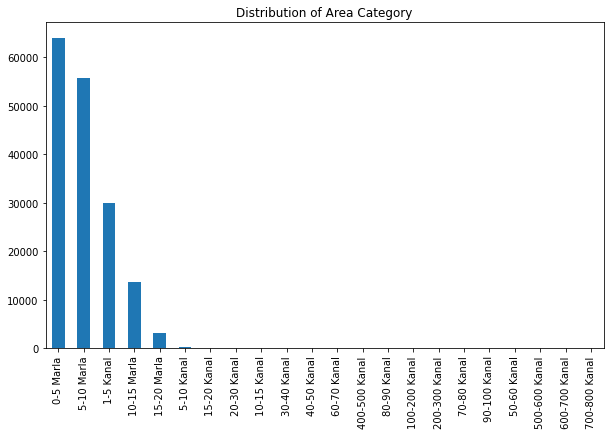

In [0]:
categorical_features = ["property_type", "location", "city", "province_name", "purpose", "Area Type", "Area Category"]
for feature in categorical_features:
    Zameen_Data_df.select(feature).toPandas()[feature].value_counts().plot(kind='bar', figsize=(10, 6))
    plt.title(f'Distribution of {feature}')
    plt.show()

#####Ploting a histogram with a Kernel Density Estimate (KDE) for the distribution of 'Area Size'
#####Scatter plot to show the relationship between 'Area Size' and 'price'

In [0]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Area Size'], bins=30, kde=True)
plt.title('Area Size Distribution')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Area Size', y='price', data=df)
plt.title('Price vs Area Size')
plt.show()


###Feature Engineering

#####Extracting and adding new columns for year, month, day of week, and quarter from 'date_added' column

In [0]:
Zameen_Data_df = Zameen_Data_df.withColumn("year_added", year("date_added"))
Zameen_Data_df = Zameen_Data_df.withColumn("month_added", month("date_added"))
Zameen_Data_df = Zameen_Data_df.withColumn("day_of_week_added", dayofweek("date_added"))
Zameen_Data_df = Zameen_Data_df.withColumn("quarter_added", quarter("date_added"))

Zameen_Data_df.select("date_added", "year_added", "month_added", "day_of_week_added", "quarter_added").show(5)

+----------+----------+-----------+-----------------+-------------+
|date_added|year_added|month_added|day_of_week_added|quarter_added|
+----------+----------+-----------+-----------------+-------------+
|2019-02-04|      2019|          2|                2|            1|
|2019-05-04|      2019|          5|                7|            2|
|2019-07-17|      2019|          7|                4|            3|
|2019-04-05|      2019|          4|                6|            2|
|2019-07-10|      2019|          7|                4|            3|
+----------+----------+-----------+-----------------+-------------+
only showing top 5 rows



#####Calculating and adding location popularity (count) to the DataFrame by joining with location popularity data

In [0]:
location_popularity = Zameen_Data_df.groupBy("location").count().withColumnRenamed("count", "location_popularity")
Zameen_Data_df = Zameen_Data_df.join(location_popularity, on="location", how="left")

#####Displaying the 'location' and its corresponding 'location_popularity' values

In [0]:
Zameen_Data_df.select("location", "location_popularity").show(5)

+-----------+-------------------+
|   location|location_popularity|
+-----------+-------------------+
|       G-10|                624|
|       E-11|               2732|
|       G-15|               1201|
|  Bani Gala|               1235|
|DHA Defence|              21905|
+-----------+-------------------+
only showing top 5 rows



#####Creating a new column 'price_category' based on price ranges: Low, Medium, and High

In [0]:
Zameen_Data_df = Zameen_Data_df.withColumn("price_category", 
                                           when(col("price") < 10000000, "Low")
                                           .when((col("price") >= 10000000) & (col("price") < 30000000), "Medium")
                                           .otherwise("High"))

#####Creating a new column 'property_options' combining 'city' and 'location' based on 'price_category'

In [0]:
Zameen_Data_df = Zameen_Data_df.withColumn("property_options", 
                                           when(col("price_category") == "Low", 
                                                concat(col("city"), lit(" - "), col("location")))
                                           .when(col("price_category") == "Medium", 
                                                concat(col("city"), lit(" - "), col("location")))
                                           .when(col("price_category") == "High", 
                                                concat(col("city"), lit(" - "), col("location")))
                                           .otherwise(concat(col("city"), lit(" - "), col("location")))  
                                        )

#####Displaying the first 10 rows of selected columns without truncating the content

In [0]:
Zameen_Data_df.select("price", "price_category", "province_name", "property_options", "property_type", "area", "purpose","page_url").show(10, truncate=False)

+--------+--------------+-----------------+-----------------------+-------------+---------+--------+---------------------------------------------------------------------------------------------------------------------------------------------------------+
|price   |price_category|province_name    |property_options       |property_type|area     |purpose |page_url                                                                                                                                                 |
+--------+--------------+-----------------+-----------------------+-------------+---------+--------+---------------------------------------------------------------------------------------------------------------------------------------------------------+
|10000000|Medium        |Islamabad Capital|Islamabad - G-10       |Flat         |4 Marla  |For Sale|https://www.zameen.com/Property/g_10_g_10_2_ground_floor_corner_apartment_with_green_lawn_for_sale-237062-3325-1.html                  

#####Adding a new column 'age_of_property' representing the number of years since 'date_added'

In [0]:
Zameen_Data_df = Zameen_Data_df.withColumn("age_of_property", year(current_date()) - year(col("date_added")))

#####Displaying the 'date_added' and 'age_of_property' columns for the first 5 rows

In [0]:
Zameen_Data_df.select("date_added","age_of_property").show(5)

+----------+---------------+
|date_added|age_of_property|
+----------+---------------+
|2019-02-04|              5|
|2019-05-04|              5|
|2019-07-17|              5|
|2019-04-05|              5|
|2019-07-10|              5|
+----------+---------------+
only showing top 5 rows



#####Adding a new column 'neighborhood_avg_price' with the average price for each 'location'

In [0]:
window_spec = Window.partitionBy("location")
Zameen_Data_df = Zameen_Data_df.withColumn("neighborhood_avg_price", avg("price").over(window_spec))

#####Displaying the first 10 rows of the 'neighborhood_avg_price' column

In [0]:
Zameen_Data_df.select("neighborhood_avg_price").show(10)

+----------------------+
|neighborhood_avg_price|
+----------------------+
|             7530000.0|
|             7530000.0|
|             7530000.0|
|             7530000.0|
|  1.0347857142857144E7|
|  1.0347857142857144E7|
|  1.0347857142857144E7|
|  1.0347857142857144E7|
|  1.0347857142857144E7|
|  1.0347857142857144E7|
+----------------------+
only showing top 10 rows



#####Adding a new column 'renovation_indicator' with value 1 if 'page_url' contains 'renovated', otherwise 0

In [0]:
    Zameen_Data_df = Zameen_Data_df.withColumn("renovation_indicator", when(Zameen_Data_df.page_url.contains("renovated"), lit(1)).otherwise(lit(0)))

#####Displaying the first 5 rows of the 'renovation_indicator' column

In [0]:
Zameen_Data_df.select("renovation_indicator").show(5)

+--------------------+
|renovation_indicator|
+--------------------+
|                   0|
|                   0|
|                   0|
|                   0|
|                   0|
+--------------------+
only showing top 5 rows



#####Adding a new column 'adjusted_price_per_area' with price adjusted for depreciation based on property age

In [0]:
depreciation_rate = 0.02  # 2% depreciation per year
Zameen_Data_df = Zameen_Data_df.withColumn("adjusted_price_per_area", col("price") / (col("Area Size") * (1 + col("age_of_property") * depreciation_rate)))

#####Displaying the first 10 rows of the 'adjusted_price_per_area' column

In [0]:
Zameen_Data_df.select("adjusted_price_per_area").show(10)

+-----------------------+
|adjusted_price_per_area|
+-----------------------+
|     2272727.2727272725|
|       1120129.87012987|
|     1874999.9999999998|
|    1.977272727272727E7|
|      795454.5454545454|
|   1.9602272727272723E7|
|   2.4545454545454543E7|
|     1143695.0146627564|
|    4.464285714285714E7|
|    3.636363636363636E7|
+-----------------------+
only showing top 10 rows



#####Printing the schema (column names and types) of the DataFrame

In [0]:
Zameen_Data_df.printSchema()

root
 |-- location: string (nullable = true)
 |-- property_id: integer (nullable = true)
 |-- location_id: integer (nullable = true)
 |-- page_url: string (nullable = true)
 |-- property_type: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- province_name: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- baths: integer (nullable = true)
 |-- area: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- date_added: date (nullable = true)
 |-- agency: string (nullable = false)
 |-- agent: string (nullable = false)
 |-- Area Type: string (nullable = true)
 |-- Area Size: double (nullable = true)
 |-- Area Category: string (nullable = true)
 |-- year_added: integer (nullable = true)
 |-- month_added: integer (nullable = true)
 |-- day_of_week_added: integer (nullable = true)
 |-- quarter_added: integer (nullable = true)
 

#####Saving the DataFrame with new features to a CSV file.

In [0]:
Zameen_Data_df.write.csv("/FileStore/tables/new_feature_data.csv", header=True, mode="overwrite")

###Outlier Analysis

#####Renaming 'Area Size' column to 'Area_Size' and detecting outliers in specified numerical features using IQR method

In [0]:
Zameen_Data_df = Zameen_Data_df.withColumnRenamed("Area Size", "Area_Size")
def detect_outliers(df, column):

    quantiles = df.approxQuantile(column, [0.25, 0.75], 0.05)
    Q1 = quantiles[0]
    Q3 = quantiles[1]
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df = df.withColumn(f"{column}_outlier", expr(f"CASE WHEN {column} < {lower_bound} OR {column} > {upper_bound} THEN 1 ELSE 0 END"))
    return df

# Apply the function to numerical features
numeric_features = ["latitude", "longitude", "baths", "bedrooms", "Area_Size","age_of_property", "neighborhood_avg_price", "adjusted_price_per_area","location_popularity"]
for feature in numeric_features:
    Zameen_Data_df = detect_outliers(Zameen_Data_df, feature)

Zameen_Data_df = detect_outliers(Zameen_Data_df, "price")


#####Filtering and displaying rows where 'price' is detected as an outlier, showing selected columns

In [0]:
outliers_df = Zameen_Data_df.filter(col("price_outlier") == 1)
outliers_df.select("price", "location", "property_type", "bedrooms", "baths", "Area_Size").show()

+---------+------------------+-------------+--------+-----+---------+
|    price|          location|property_type|bedrooms|baths|Area_Size|
+---------+------------------+-------------+--------+-----+---------+
| 43500000|         Bani Gala|        House|       4|    4|      2.0|
| 50000000|       DHA Defence|        House|       7|    7|      1.0|
| 48000000|Diplomatic Enclave|         Flat|       2|    2|      7.8|
|400000000|               F-6|        House|       0|    0|      4.5|
| 80000000|       DHA Defence|        House|       7|    7|      2.0|
| 55000000|              G-11|        House|       6|    7|     14.0|
| 88500000|         Bani Gala|   Farm House|       3|    3|      6.0|
| 47000000|Diplomatic Enclave|         Flat|       3|    2|      8.4|
|100000000|               F-6|        House|       5|    5|     17.8|
|220000000|               F-7|        House|      10|   10|      2.1|
|230000000|               E-7|        House|       4|    4|      2.5|
|220000000|        M

#####Displaying the first 5 rows of outlier detection columns for numerical features

In [0]:
Zameen_Data_df.select([f"{feature}_outlier" for feature in numeric_features]).show(5)

+----------------+-----------------+-------------+----------------+-----------------+-----------------------+------------------------------+-------------------------------+---------------------------+
|latitude_outlier|longitude_outlier|baths_outlier|bedrooms_outlier|Area_Size_outlier|age_of_property_outlier|neighborhood_avg_price_outlier|adjusted_price_per_area_outlier|location_popularity_outlier|
+----------------+-----------------+-------------+----------------+-----------------+-----------------------+------------------------------+-------------------------------+---------------------------+
|               0|                0|            0|               0|                0|                      0|                             0|                              0|                          0|
|               0|                0|            0|               0|                0|                      0|                             0|                              0|                        

#####Filtering out rows where any numerical feature is flagged as an outlier

In [0]:
for feature in numeric_features:
    Zameen_Data_df = Zameen_Data_df.filter(col(f"{feature}_outlier") == 0)

##### Displaying the columns that had outliers detected

In [0]:
outlier_columns = [f"{feature}_outlier" for feature in numeric_features]
outlier_columns_df = Zameen_Data_df.select(outlier_columns).agg(*[sum(col(c)).alias(c) for c in outlier_columns])
outlier_columns_df.show()

#####Droping the outlier detected columns from the DataFrame

In [0]:
Zameen_Data_df = Zameen_Data_df.drop(*[f"{feature}_outlier" for feature in numeric_features])

#####Showing summary statistics (count, mean, stddev, min, max) for the numerical features

In [0]:
Zameen_Data_df.select(numeric_features).describe().show()

+-------+------------------+------------------+-----------------+------------------+------------------+---------------+----------------------+-----------------------+-------------------+
|summary|          latitude|         longitude|            baths|          bedrooms|         Area_Size|age_of_property|neighborhood_avg_price|adjusted_price_per_area|location_popularity|
+-------+------------------+------------------+-----------------+------------------+------------------+---------------+----------------------+-----------------------+-------------------+
|  count|            117757|            117757|           117757|            117757|            117757|         117757|                117757|                 117745|             117757|
|   mean| 30.02653209189278| 71.27338869795422|2.482519085914213| 2.810762842124035| 6.217778136331401|            5.0|  1.2669478391314834E7|     1282252.5406002926|  2615.981894919198|
| stddev|3.8013784452182082|3.0533305361000855|2.014223147322675|

In [0]:
Zameen_Data_df.printSchema()

root
 |-- location: string (nullable = true)
 |-- property_id: integer (nullable = true)
 |-- location_id: integer (nullable = true)
 |-- page_url: string (nullable = true)
 |-- property_type: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- province_name: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- baths: integer (nullable = true)
 |-- area: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- date_added: date (nullable = true)
 |-- agency: string (nullable = false)
 |-- agent: string (nullable = false)
 |-- Area Type: string (nullable = true)
 |-- Area_Size: double (nullable = true)
 |-- Area Category: string (nullable = true)
 |-- year_added: integer (nullable = true)
 |-- month_added: integer (nullable = true)
 |-- day_of_week_added: integer (nullable = true)
 |-- quarter_added: integer (nullable = true)
 

###Encoding and Indexing Categorial features

#####Encoding categorical columns using StringIndexer to convert them into numerical indices,
#####then use OneHotEncoder to convert these indices into one-hot encoded vectors. 
#####Apply these transformations to the DataFrame.

In [0]:
categorical_cols = ["property_type", "city", "province_name", "area", 
                    "purpose", "agency", "agent", "Area Type", 
                    "Area Category", "property_options", "price_category"]

indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="skip") for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=col+"_index", outputCol=col+"_encoded") for col in categorical_cols]
pipeline = Pipeline(stages=indexers + encoders)
Zameen_Data_df_encoded = pipeline.fit(Zameen_Data_df).transform(Zameen_Data_df)


#####Printing the schema of the DataFrame after encoding categorical columns

In [0]:
Zameen_Data_df_encoded.printSchema()

root
 |-- location: string (nullable = true)
 |-- property_id: integer (nullable = true)
 |-- location_id: integer (nullable = true)
 |-- page_url: string (nullable = true)
 |-- property_type: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- province_name: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- baths: integer (nullable = true)
 |-- area: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- date_added: date (nullable = true)
 |-- agency: string (nullable = false)
 |-- agent: string (nullable = false)
 |-- Area Type: string (nullable = true)
 |-- Area_Size: double (nullable = true)
 |-- Area Category: string (nullable = true)
 |-- year_added: integer (nullable = true)
 |-- month_added: integer (nullable = true)
 |-- day_of_week_added: integer (nullable = true)
 |-- quarter_added: integer (nullable = true)
 

#####Displaying the first 5 rows of the 'price_category_encoded' column

In [0]:
Zameen_Data_df_encoded.select("price_category_encoded").show(5)

+----------------------+
|price_category_encoded|
+----------------------+
|         (2,[1],[1.0])|
|         (2,[1],[1.0])|
|         (2,[0],[1.0])|
|         (2,[0],[1.0])|
|         (2,[0],[1.0])|
+----------------------+
only showing top 5 rows



#####Showing summary statistics (count, mean, stddev, min, max) for specified numerical columns

In [0]:
Zameen_Data_df_encoded.describe([
    "price", "latitude", "longitude", "baths", "bedrooms", "Area_Size", 
    "age_of_property", "neighborhood_avg_price", "adjusted_price_per_area", 
    "year_added", "month_added", "day_of_week_added", "quarter_added", 
    "location_popularity"
]).show(5)


+-------+-----------------+------------------+-----------------+-----------------+-----------------+------------------+---------------+----------------------+-----------------------+--------------------+-----------------+------------------+------------------+-------------------+
|summary|            price|          latitude|        longitude|            baths|         bedrooms|         Area_Size|age_of_property|neighborhood_avg_price|adjusted_price_per_area|          year_added|      month_added| day_of_week_added|     quarter_added|location_popularity|
+-------+-----------------+------------------+-----------------+-----------------+-----------------+------------------+---------------+----------------------+-----------------------+--------------------+-----------------+------------------+------------------+-------------------+
|  count|           117757|            117757|           117757|           117757|           117757|            117757|         117757|                117757|  

#####Defining a list of numerical columns for further processing or analysis

In [0]:
numerical_cols = [
    "price", "latitude", "longitude", "baths", "bedrooms", "Area_Size", 
    "age_of_property", "neighborhood_avg_price", "adjusted_price_per_area", 
    "location_popularity"
]

#####Filling missing values with 0 for the specified numerical columns

In [0]:
Zameen_Data_df_encoded = Zameen_Data_df_encoded.fillna(0, subset=numerical_cols)

##Scaling and Assembling Numerical features

#####Assemble numerical columns into a feature vector and scale the features with StandardScaler.
#####Apply these transformations using a pipeline to standardize the numerical features.

In [0]:

assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features")
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
pipeline = Pipeline(stages=[assembler, scaler])
Zameen_Data_df_scaled = pipeline.fit(Zameen_Data_df_encoded).transform(Zameen_Data_df_encoded)

#####Displaying the 'scaled_features' column with full content

In [0]:
    Zameen_Data_df_scaled.select("scaled_features").show(truncate=False)

+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|scaled_features                                                                                                                                                                         |
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[0.6382972551615465,0.3757997943891016,0.9705705743316254,1.2498520421791672,0.7028571453486255,1.2277692629417585,0.0,3.3596832890937276,0.09276255313448063,-0.9092664113171631]      |
|[1.3899926437711163,0.3761603662237013,0.9705655077330994,1.746321364026258,0.7028571453486255,0.6111440195602935,0.0,3.3596832890937276,1.1838288875065788,-0.9092664113171631]        |
|[-0.3138502370772421,0.3761603662237013,0.9705655077330994,-0.23

In [0]:
Zameen_Data_df_scaled.printSchema()

root
 |-- location: string (nullable = true)
 |-- property_id: integer (nullable = true)
 |-- location_id: integer (nullable = true)
 |-- page_url: string (nullable = true)
 |-- property_type: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- province_name: string (nullable = true)
 |-- latitude: double (nullable = false)
 |-- longitude: double (nullable = false)
 |-- baths: integer (nullable = true)
 |-- area: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- date_added: date (nullable = true)
 |-- agency: string (nullable = false)
 |-- agent: string (nullable = false)
 |-- Area Type: string (nullable = true)
 |-- Area_Size: double (nullable = false)
 |-- Area Category: string (nullable = true)
 |-- year_added: integer (nullable = true)
 |-- month_added: integer (nullable = true)
 |-- day_of_week_added: integer (nullable = true)
 |-- quarter_added: integer (nullable = true

###Predictive Modeling

#####Spliting the data into training (80%) and testing (20%) sets

In [0]:
train_data, test_data = Zameen_Data_df_scaled.randomSplit([0.8, 0.2], seed=42)

#####Train a Linear Regression model using 'scaled_features' as features and 'price' as the label

In [0]:
LR = LinearRegression(featuresCol="scaled_features", labelCol="price")
Predictive_model = LR.fit(train_data)

#####Making predictions on the test data using the trained Linear Regression model

In [0]:
predictions = Predictive_model.transform(test_data)


#####Evaluating the model's performance using Root Mean Squared Error (RMSE) and print the result

In [0]:
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="price", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data: {rmse}")

Root Mean Squared Error (RMSE) on test data: 0.05816822995542817


#####Displaying the actual 'price', predicted 'prediction', and 'scaled_features' for the first 5 rows of predictions

In [0]:
predictions.select("price", "prediction", "scaled_features").show(5)

+--------+--------------------+--------------------+
|   price|          prediction|     scaled_features|
+--------+--------------------+--------------------+
| 6600000|   6599999.937874025|[-0.2537146059884...|
|21000000| 2.099999996427477E7|[1.18954054014189...|
|15500000|1.5500000101418048E7|[0.63829725516154...|
|19000000| 1.900000011994852E7|[0.98908843651267...|
|25000000| 2.500000010452362E7|[1.59044474740033...|
+--------+--------------------+--------------------+
only showing top 5 rows



#####Converting the 'price' and 'prediction' columns to a Pandas DataFrame and create a scatter plot 
#####comparing actual vs predicted prices with a reference line showing perfect predictions

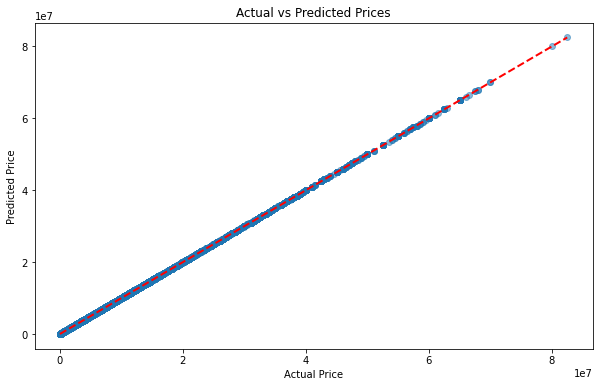

In [0]:
predictions_pd = predictions.select("price", "prediction").toPandas()

# Scatter plot of actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd['price'], predictions_pd['prediction'], alpha=0.5)
plt.plot([predictions_pd['price'].min(), predictions_pd['price'].max()], 
         [predictions_pd['price'].min(), predictions_pd['price'].max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.show()

###Future Price Prediction

##### In order to perform future price prediction, we first read the new data from a CSV file. To ensure that the new data is compatible with the trained model, it must have the same structure and features as the data used during training. This involves preprocessing the new data to match the feature engineering steps and transformations applied to the training dataset. By maintaining consistency in the data structure and features, we can ensure that the trained model can accurately make predictions on the new data.

##### The CSV file contains hypothetical scenarios for future property price predictions. It allows us to estimate prices based on specific property characteristics and locations using the trained model

#####Reading/Loading a new CSV file into a DataFrame with headers and automatic type inference

In [0]:
Neww_Dataa_df = spark.read.csv("/FileStore/tables/Test_Data-2.csv", header=True, inferSchema=True)

#####Printing the schema (column names and types) of the new DataFrame

In [0]:
Neww_Dataa_df.printSchema()

root
 |-- property_id: integer (nullable = true)
 |-- location_id: integer (nullable = true)
 |-- page_url: string (nullable = true)
 |-- property_type: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- location: string (nullable = true)
 |-- city: string (nullable = true)
 |-- province_name: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- baths: integer (nullable = true)
 |-- area: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- date_added: date (nullable = true)
 |-- agency: string (nullable = true)
 |-- agent: string (nullable = true)
 |-- Area Type: string (nullable = true)
 |-- Area Size: double (nullable = true)
 |-- Area Category: string (nullable = true)



In [0]:
#Neww_Dataa_df = Neww_Dataa_df.drop("_c20", "_c21")

In [0]:
Neww_Dataa_df.show(5)

+-----------+-----------+--------------------+-------------+------+--------------------+----------+-------------+---------+---------+-----+----------+--------+--------+----------+------------------+------------------+---------+---------+-------------+
|property_id|location_id|            page_url|property_type| price|            location|      city|province_name| latitude|longitude|baths|      area| purpose|bedrooms|date_added|            agency|             agent|Area Type|Area Size|Area Category|
+-----------+-----------+--------------------+-------------+------+--------------------+----------+-------------+---------+---------+-----+----------+--------+--------+----------+------------------+------------------+---------+---------+-------------+
|    7336017|      10610|https://www.zamee...|        House| 23000|Bahria Town Rawal...|Rawalpindi|       Punjab| 33.50136|73.108691|    2|   5 Marla|For Rent|       2|2019-07-08|      Madni Estate|          Mr Imran|    Marla|      5.0|    0-5

#####Calculating the number of missing values for each column in the new DataFrame

In [0]:
missing_value_df = Neww_Dataa_df.select( [sum(col(c).isNull().cast("int")).alias(c) for c in Neww_Dataa_df.columns])

In [0]:
missing_value_df.show()

+-----------+-----------+--------+-------------+-----+--------+----+-------------+--------+---------+-----+----+-------+--------+----------+------+-----+---------+---------+-------------+
|property_id|location_id|page_url|property_type|price|location|city|province_name|latitude|longitude|baths|area|purpose|bedrooms|date_added|agency|agent|Area Type|Area Size|Area Category|
+-----------+-----------+--------+-------------+-----+--------+----+-------------+--------+---------+-----+----+-------+--------+----------+------+-----+---------+---------+-------------+
|          0|          0|       0|            0|    0|       0|   0|            0|       0|        0|    0|   0|      0|       0|         0|  1130| 1130|        0|        0|            0|
+-----------+-----------+--------+-------------+-----+--------+----+-------------+--------+---------+-----+----+-------+--------+----------+------+-----+---------+---------+-------------+



#####Filling missing values in 'agency' and 'agent' columns with 'unknown' in the new DataFrame

In [0]:
Neww_Dataa_df = Neww_Dataa_df.fillna({"agency": "unknown", "agent": "unknown" })

#####Displaying the count of missing values for each column in the new DataFrame

In [0]:
 Neww_Dataa_df.select( [sum(col(c).isNull().cast("int")).alias(c) for c in Neww_Dataa_df.columns]).show()

+-----------+-----------+--------+-------------+-----+--------+----+-------------+--------+---------+-----+----+-------+--------+----------+------+-----+---------+---------+-------------+
|property_id|location_id|page_url|property_type|price|location|city|province_name|latitude|longitude|baths|area|purpose|bedrooms|date_added|agency|agent|Area Type|Area Size|Area Category|
+-----------+-----------+--------+-------------+-----+--------+----+-------------+--------+---------+-----+----+-------+--------+----------+------+-----+---------+---------+-------------+
|          0|          0|       0|            0|    0|       0|   0|            0|       0|        0|    0|   0|      0|       0|         0|     0|    0|        0|        0|            0|
+-----------+-----------+--------+-------------+-----+--------+----+-------------+--------+---------+-----+----+-------+--------+----------+------+-----+---------+---------+-------------+



#####Showing summary statistics (count, mean, stddev, min, max) for selected columns in the new DataFrame

In [0]:
Neww_Dataa_df.select("property_id", "location_id" ,"price", "latitude", "longitude", "baths", "bedrooms", "Area Size").describe().show()

+-------+-----------------+------------------+--------------------+------------------+-----------------+------------------+------------------+-----------------+
|summary|      property_id|       location_id|               price|          latitude|        longitude|             baths|          bedrooms|        Area Size|
+-------+-----------------+------------------+--------------------+------------------+-----------------+------------------+------------------+-----------------+
|  count|             1500|              1500|                1500|              1500|             1500|              1500|              1500|             1500|
|   mean|8082575.894666667|          4341.926|1.8714743333333332E7|30.138854072433254|71.54305631605332|3.3266666666666667|             3.408|6.160933333333338|
| stddev|277211.5510239363|3649.0727564472113| 3.460428486571429E7|3.6706317659892145|3.076786979102814|  2.30264130805283|1.9332255189893168|3.797500204181173|
|    min|          6975141|       

#####Group by each specified column and count the number of occurrences in the new DataFrame

In [0]:
for column in ["property_type", "location", "city", "province_name", "purpose", "Area Type", "Area Category"]:
    Neww_Dataa_df.groupBy(column).count().show()

+-------------+-----+
|property_type|count|
+-------------+-----+
|   Farm House|    6|
|         Flat|  362|
|    Penthouse|   10|
|         Room|    8|
|        House|  967|
|Upper Portion|   77|
|Lower Portion|   70|
+-------------+-----+

+--------------------+-----+
|            location|count|
+--------------------+-----+
|Marghzar Officers...|    1|
|      Cavalry Ground|    3|
|          Nawab Town|    3|
|      Nishtar Colony|    2|
|Punjab Small Indu...|    2|
|            Township|   13|
|   Dhok Sayedan Road|    1|
|         Liaquatabad|    3|
|        Narwala Road|    1|
|         Sarwar Road|    1|
|       Pakistan Town|    5|
|       Jhangi Syedan|    1|
|            CBR Town|    1|
|Airline Housing S...|    1|
|Khayaban-e-Jinnah...|    1|
|      Ferozepur Road|    4|
|Islamabad Expressway|    2|
|PCSIR Housing Scheme|    4|
|         Kot Lakhpat|    1|
|         Bath Island|    4|
+--------------------+-----+
only showing top 20 rows

+----------+-----+
|      city|coun

#####Adding new columns to the new DataFrame:
######- 'year_added', 'month_added', 'day_of_week_added', and 'quarter_added' from 'date_added'
######- 'price_category' based on price ranges: Low, Medium, High
######- 'property_options' combining 'city' and 'location' based on 'price_category'
######- 'age_of_property' representing years since 'date_added'
######- 'neighborhood_avg_price' with the average price per 'location'
######- 'renovation_indicator' as 1 if 'page_url' contains 'renovated', otherwise 0
######- 'adjusted_price_per_area' adjusted for depreciation based on property age

In [0]:
Neww_Dataa_df = Neww_Dataa_df.withColumn("year_added", year("date_added"))
Neww_Dataa_df = Neww_Dataa_df.withColumn("month_added", month("date_added"))
Neww_Dataa_df = Neww_Dataa_df.withColumn("day_of_week_added", dayofweek("date_added"))
Neww_Dataa_df = Neww_Dataa_df.withColumn("quarter_added", quarter("date_added"))

location_popularity = Neww_Dataa_df.groupBy("location").count().withColumnRenamed("count", "location_popularity")
Neww_Dataa_df = Neww_Dataa_df.join(location_popularity, on="location", how="left")


Neww_Dataa_df = Neww_Dataa_df.withColumn("price_category", 
                                           when(col("price") < 10000000, "Low")
                                           .when((col("price") >= 10000000) & (col("price") < 30000000), "Medium")
                                           .otherwise("High"))

Neww_Dataa_df = Neww_Dataa_df.withColumn("property_options", 
                                           when(col("price_category") == "Low", 
                                                concat(col("city"), lit(" - "), col("location")))
                                           .when(col("price_category") == "Medium", 
                                                concat(col("city"), lit(" - "), col("location")))
                                           .when(col("price_category") == "High", 
                                                concat(col("city"), lit(" - "), col("location")))
                                           .otherwise(concat(col("city"), lit(" - "), col("location")))  
                                        )


Neww_Dataa_df = Neww_Dataa_df.withColumn("age_of_property", year(current_date()) - year(col("date_added")))

window_spec = Window.partitionBy("location")
Neww_Dataa_df = Neww_Dataa_df.withColumn("neighborhood_avg_price", avg("price").over(window_spec))


Neww_Dataa_df = Neww_Dataa_df.withColumn("renovation_indicator", when(Neww_Dataa_df.page_url.contains("renovated"), lit(1)).otherwise(lit(0)))


Neww_Dataa_df = Neww_Dataa_df.withColumn("adjusted_price_per_area", col("price") / (col("Area Size") * (1 + col("age_of_property") * depreciation_rate)))

In [0]:
Neww_Dataa_df.printSchema()

root
 |-- location: string (nullable = true)
 |-- property_id: integer (nullable = true)
 |-- location_id: integer (nullable = true)
 |-- page_url: string (nullable = true)
 |-- property_type: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- province_name: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- baths: integer (nullable = true)
 |-- area: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- date_added: date (nullable = true)
 |-- agency: string (nullable = false)
 |-- agent: string (nullable = false)
 |-- Area Type: string (nullable = true)
 |-- Area Size: double (nullable = true)
 |-- Area Category: string (nullable = true)
 |-- year_added: integer (nullable = true)
 |-- month_added: integer (nullable = true)
 |-- day_of_week_added: integer (nullable = true)
 |-- quarter_added: integer (nullable = true)
 

#####Detecting and flaging outliers in numerical features using the IQR method

In [0]:
Neww_Dataa_df = Neww_Dataa_df.withColumnRenamed("Area Size", "Area_Size")

for feature in numeric_features:
    Neww_Dataa_df = detect_outliers(Neww_Dataa_df, feature)

Neww_Dataa_df = detect_outliers(Neww_Dataa_df, "price")


#####Filtering and display rows where 'price' is detected as an outlier in the new DataFrame

In [0]:
outliers_New_df = Neww_Dataa_df.filter(col("price_outlier") == 1)
outliers_New_df.select("price", "location", "property_type", "bedrooms", "baths", "Area_Size").show()

+---------+--------------------+-------------+--------+-----+---------+
|    price|            location|property_type|bedrooms|baths|Area_Size|
+---------+--------------------+-------------+--------+-----+---------+
|150000000|             Zamzama|        House|       5|    6|     14.0|
| 77500000|        Jamshed Town|        House|       7|    8|      1.2|
| 92500000|         DHA Defence|        House|       4|    5|      1.1|
| 98000000|Navy Housing Sche...|        House|       5|    6|     14.0|
| 82500000|         DHA Defence|         Flat|       4|    4|     14.2|
| 50000000|PCSIR Housing Scheme|        House|       5|    7|     18.0|
| 67800000|         DHA Defence|        House|       6|    7|      1.0|
| 47500000|         DHA Defence|        House|       5|    0|      1.0|
| 60000000|         DHA Defence|        House|       5|    6|      1.0|
|125000000|                Eden|        House|       9|    9|      2.0|
|137500000|          Johar Town|        House|       5|    5|   

#####Filtering and display rows where 'price' is flagged as an outlier in the new DataFrame

In [0]:
Neww_Dataa_df.select([f"{feature}_outlier" for feature in numeric_features]).show(5)

+----------------+-----------------+-------------+----------------+-----------------+-----------------------+------------------------------+-------------------------------+---------------------------+
|latitude_outlier|longitude_outlier|baths_outlier|bedrooms_outlier|Area_Size_outlier|age_of_property_outlier|neighborhood_avg_price_outlier|adjusted_price_per_area_outlier|location_popularity_outlier|
+----------------+-----------------+-------------+----------------+-----------------+-----------------------+------------------------------+-------------------------------+---------------------------+
|               0|                0|            0|               0|                0|                      0|                             0|                              0|                          0|
|               0|                0|            0|               0|                0|                      0|                             0|                              0|                        

#####Removing rows where any numerical feature is flagged as an outlier from the new DataFrame

In [0]:
for feature in numeric_features:
    Neww_Dataa_df = Neww_Dataa_df.filter(col(f"{feature}_outlier") == 0)

#####Droping outlier detection columns from the new DataFrame

In [0]:
Neww_Dataa_df = Neww_Dataa_df.drop(*[f"{feature}_outlier" for feature in numeric_features])

#####Showing summary statistics (count, mean, stddev, min, max) for the numerical columns in the new DataFrame

In [0]:
Neww_Dataa_df.select(numeric_features).describe().show()

+-------+------------------+-----------------+------------------+------------------+-----------------+---------------+----------------------+-----------------------+-------------------+
|summary|          latitude|        longitude|             baths|          bedrooms|        Area_Size|age_of_property|neighborhood_avg_price|adjusted_price_per_area|location_popularity|
+-------+------------------+-----------------+------------------+------------------+-----------------+---------------+----------------------+-----------------------+-------------------+
|  count|              1066|             1066|              1066|              1066|             1066|           1066|                  1066|                   1066|               1066|
|   mean| 29.89521485171665|71.39081156401511|2.9709193245778613|3.0628517823639774|6.579455909943719|            5.0|  1.2417209919054182E7|     1270347.8378592336| 13.799249530956848|
| stddev|3.6818317922323796| 3.13710719518751|2.0187149026730085| 1.63

In [0]:
Neww_Dataa_df.printSchema()

root
 |-- location: string (nullable = true)
 |-- property_id: integer (nullable = true)
 |-- location_id: integer (nullable = true)
 |-- page_url: string (nullable = true)
 |-- property_type: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- province_name: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- baths: integer (nullable = true)
 |-- area: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- date_added: date (nullable = true)
 |-- agency: string (nullable = false)
 |-- agent: string (nullable = false)
 |-- Area Type: string (nullable = true)
 |-- Area_Size: double (nullable = true)
 |-- Area Category: string (nullable = true)
 |-- year_added: integer (nullable = true)
 |-- month_added: integer (nullable = true)
 |-- day_of_week_added: integer (nullable = true)
 |-- quarter_added: integer (nullable = true)
 

#####Cast specified columns to integer type for the new DataFrame

In [0]:
Neww_Dataa_df = Neww_Dataa_df \
    .withColumn("property_id", col("property_id").cast("integer")) \
    .withColumn("location_id", col("location_id").cast("integer")) \
    .withColumn("price", col("price").cast("integer")) \
    .withColumn("baths", col("baths").cast("integer")) \
    .withColumn("bedrooms", col("bedrooms").cast("integer"))

In [0]:
#Neww_Dataa_df = Neww_Dataa_df.withColumn(
 #   "purpose",
  #  when((col("property_type") == "House") & (col("purpose") == "For Rent"), "For Sale").otherwise(col("purpose"))
#)

#####Encoding categorical columns using StringIndexer and OneHotEncoder, then apply these transformations using a pipeline

In [0]:

indexerss = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid="skip") for col in categorical_cols]
encoderss = [OneHotEncoder(inputCol=col+"_index", outputCol=col+"_encoded") for col in categorical_cols]
pipelinee = Pipeline(stages=indexerss + encoderss)

Neww_Dataa_df_encoded = pipelinee.fit(Neww_Dataa_df).transform(Neww_Dataa_df)

#####Displaying the first 5 rows of the 'price_category_encoded' column

In [0]:
Neww_Dataa_df_encoded.select("price_category_encoded").show(5)

+----------------------+
|price_category_encoded|
+----------------------+
|         (2,[0],[1.0])|
|         (2,[1],[1.0])|
|         (2,[1],[1.0])|
|         (2,[0],[1.0])|
|         (2,[0],[1.0])|
+----------------------+
only showing top 5 rows



In [0]:
Neww_Dataa_df.printSchema()

root
 |-- location: string (nullable = true)
 |-- property_id: integer (nullable = true)
 |-- location_id: integer (nullable = true)
 |-- page_url: string (nullable = true)
 |-- property_type: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- province_name: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- baths: integer (nullable = true)
 |-- area: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- date_added: date (nullable = true)
 |-- agency: string (nullable = false)
 |-- agent: string (nullable = false)
 |-- Area Type: string (nullable = true)
 |-- Area_Size: double (nullable = true)
 |-- Area Category: string (nullable = true)
 |-- year_added: integer (nullable = true)
 |-- month_added: integer (nullable = true)
 |-- day_of_week_added: integer (nullable = true)
 |-- quarter_added: integer (nullable = true)
 

#####Assembling numerical columns into a feature vector and standardize these features with StandardScaler using a pipeline

In [0]:
assemblerr = VectorAssembler(inputCols=numerical_cols, outputCol="features")
scalerr = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
pipelineee = Pipeline(stages=[assemblerr, scalerr])
Neww_Dataa_df_scaled = pipelineee.fit(Neww_Dataa_df_encoded).transform(Neww_Dataa_df_encoded)

#####Displaying the 'scaled_features' column with full content

In [0]:
Neww_Dataa_df_scaled.select("scaled_features").show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|scaled_features                                                                                                                                                                            |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[-0.04963834400571578,0.40983353760666624,0.5566107013058241,1.5004994867830481,0.5748166549849116,-0.46972281392173415,0.0,-0.41890188457456795,0.404006745716948,-0.9067158982518109]    |
|[0.8876918173119678,1.0384589421900374,0.535562010301161,-0.4809591108146337,-1.8786550335592989,-0.49946234707137876,0.0,0.6843715608608851,2.2839411728895986,-0.9067158982518109]       |
|[0.1586572473982139,0.3944208291500438,0.89784481

#####Using the trained Linear Regression model to make predictions on the scaled new data

In [0]:
predictions_new_data = Predictive_model.transform(Neww_Dataa_df_scaled)

#####Displaying the first 5 rows of the 'price' and 'prediction' columns from the new data predictions

In [0]:
predictions_new_data.select("price", "prediction").show(5)

+--------+--------------------+
|   price|          prediction|
+--------+--------------------+
| 9000000|   8636159.913503261|
|18000000|1.7988320649041105E7|
|11000000|1.0714417882498149E7|
| 4700000|  4167905.1926556136|
| 3200000|   2609211.700784724|
+--------+--------------------+
only showing top 5 rows



#####Evaluating the model's performance on new data using Mean Absolute Error (MAE) and Mean Squared Error (MSE), then print the results

In [0]:
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="price", metricName="mae")
mae = evaluator.evaluate(predictions_new_data)
print(f"Mean Absolute Error (MAE) on new data: {mae}")

evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="price", metricName="mse")
mse = evaluator.evaluate(predictions_new_data)
print(f"Mean Squared Error (MSE) on new data: {mse}")

Mean Absolute Error (MAE) on new data: 450884.4123565711
Mean Squared Error (MSE) on new data: 260179483286.33023


#####Converting the Spark DataFrame of predictions to Pandas, and create a scatter plot comparing actual prices to predicted prices Adding a reference line showing perfect predictions

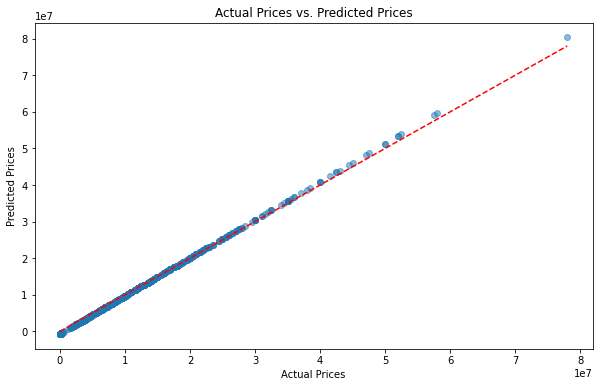

In [0]:
# Convert the DataFrame to Pandas for plotting
predictions_pd = predictions_new_data.select("price", "prediction").toPandas()

# Plot the actual prices vs. predicted prices
plt.figure(figsize=(10, 6))
plt.scatter(predictions_pd["price"], predictions_pd["prediction"], alpha=0.5)
plt.plot([predictions_pd["price"].min(), predictions_pd["price"].max()], [predictions_pd["price"].min(), predictions_pd["price"].max()], 'r--')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual Prices vs. Predicted Prices')
plt.show()


###Data Analysis and Insights

#####Registering the DataFrame as a temporary view named 'zameen' for SQL queries

In [0]:
Zameen_Data_df.createOrReplaceTempView("zameen")

#####Calculating the average price per city from the 'zameen' table, and order the results by average price in descending order

In [0]:
avg_price_per_city = spark.sql("""
    SELECT city, AVG(price) as avg_price
    FROM zameen
    GROUP BY city
    ORDER BY avg_price DESC
""")

In [0]:
avg_price_per_city.show(10)

+----------+--------------------+
|      city|           avg_price|
+----------+--------------------+
|    Lahore|1.2707420391782891E7|
|   Karachi| 1.072150648844221E7|
|Rawalpindi|   6254652.234344341|
| Islamabad|   6244251.256362027|
|Faisalabad|   5439318.758036236|
+----------+--------------------+



#####Calculating the average price for each property type from the 'zameen' table, and order the results by average price in descending order

In [0]:
price_by_property_type = spark.sql("""
    SELECT property_type, AVG(price) as avg_price
    FROM zameen
    GROUP BY property_type
    ORDER BY avg_price DESC
""")

In [0]:
price_by_property_type.show(10)

+-------------+--------------------+
|property_type|           avg_price|
+-------------+--------------------+
|   Farm House|1.7447101769911505E7|
|        House|1.1756112236095412E7|
|    Penthouse|   9116151.162790697|
|         Flat|   7743097.121434477|
|Upper Portion|  2088257.5739060114|
|Lower Portion|   1261692.828163853|
|         Room|  222461.83368869935|
+-------------+--------------------+



#####Calculating the average price by year and month from the 'zameen' table, and display the first 5 rows of the results

In [0]:
price_trends = spark.sql("""
    SELECT year_added, month_added, AVG(price) as avg_price
    FROM zameen
    GROUP BY year_added, month_added
    ORDER BY year_added, month_added
""")
price_trends.show(5)


+----------+-----------+------------------+
|year_added|month_added|         avg_price|
+----------+-----------+------------------+
|      2019|          1|5035555.5835010065|
|      2019|          2| 8597349.291462751|
|      2019|          3| 8663073.863636363|
|      2019|          4|  9089688.80620646|
|      2019|          5| 9237545.881931655|
+----------+-----------+------------------+
only showing top 5 rows



#####Calculating the average price by location popularity from the 'zameen' table, and display the first 5 rows of the results

In [0]:
price_by_location_popularity = spark.sql("""
    SELECT location_popularity, AVG(price) as avg_price
    FROM zameen
    GROUP BY location_popularity
    ORDER BY avg_price DESC
""")
price_by_location_popularity.show(5)

+-------------------+--------------------+
|location_popularity|           avg_price|
+-------------------+--------------------+
|                334|2.3944075342465755E7|
|                232|2.2254650246305417E7|
|                200| 2.166608695652174E7|
|                196|2.0975266666666668E7|
|                205|1.9914659685863875E7|
+-------------------+--------------------+
only showing top 5 rows



#####Converting the 'price' column to a Pandas DataFrame and create a boxplot to visualize the distribution of property prices

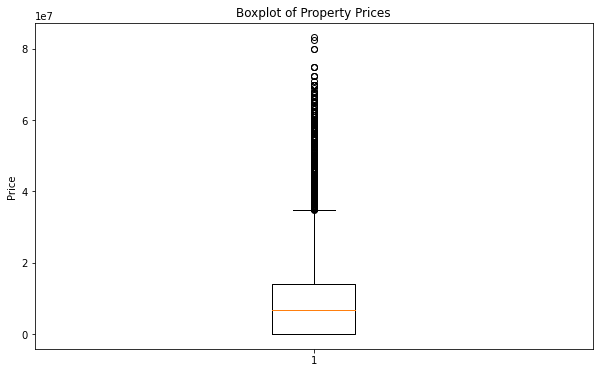

In [0]:

prices = Zameen_Data_df.select("price").toPandas()
plt.figure(figsize=(10, 6))
plt.boxplot(prices['price'])
plt.title('Boxplot of Property Prices')
plt.ylabel('Price')
plt.show()


#####Calculating the average price and count of properties for each agency from the 'zameen' table, order by average price in descending order, and display the top 10 agencies

In [0]:
agency_performance = spark.sql("""
    SELECT agency, AVG(price) as avg_price, COUNT(*) as count
    FROM zameen
    GROUP BY agency
    ORDER BY avg_price DESC
    LIMIT 10
""")
agency_performance.show(5)


+--------------------+---------+-----+
|              agency|avg_price|count|
+--------------------+---------+-----+
|     Roshan Property|   6.75E7|    1|
|  Al Nafay Marketing|    6.5E7|    1|
|Interconnect Real...| 6.4375E7|    8|
|    Maxsell Realtors|  6.125E7|    2|
|   Jamal Real Estate| 5.9375E7|    4|
+--------------------+---------+-----+
only showing top 5 rows



#####Calculating the average price by the age of the property from the 'zameen' table, and display the results ordered by the age of the property

In [0]:
price_by_age = spark.sql("""
    SELECT age_of_property, AVG(price) as avg_price
    FROM zameen
    GROUP BY age_of_property
    ORDER BY age_of_property
""")
price_by_age.show()


+---------------+-----------------+
|age_of_property|        avg_price|
+---------------+-----------------+
|              5|9131423.730606249|
+---------------+-----------------+



#####Calculate the minimum, maximum, average price, and count of properties for each property type from the 'zameen' table Order the results by average price in descending order and display the first 5 rows

In [0]:
price_distribution_by_type = spark.sql("""
    SELECT property_type, MIN(price) as min_price, 
           MAX(price) as max_price, 
           AVG(price) as avg_price,
           COUNT(*) as count
    FROM zameen
    GROUP BY property_type
    ORDER BY avg_price DESC
""")
price_distribution_by_type.show(5)


+-------------+---------+---------+--------------------+-----+
|property_type|min_price|max_price|           avg_price|count|
+-------------+---------+---------+--------------------+-----+
|   Farm House|        0| 72500000|1.7447101769911505E7|  226|
|        House|        0| 83200000|1.1756112236095412E7|69006|
|    Penthouse|    15000| 47000000|   9116151.162790697|  258|
|         Flat|        1| 80000000|   7743097.121434477|29028|
|Upper Portion|     5000| 65000000|  2088257.5739060114|11129|
+-------------+---------+---------+--------------------+-----+
only showing top 5 rows



#####Saving the trained predictive model to the specified path, overwriting any existing model at that location

In [0]:
Predictive_model.write().overwrite().save("/FileStore/tables/zameen_price_prediction_model")